In [1]:
import born_machine
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import re
import math

torch.set_default_dtype(torch.float64)
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
def leaf_node(i):
    return "L{}".format(i)


def node(i):
    return "N{}".format(i)


def make_graph(bm, threshold=0, threshold_v=1e-2):
    G = nx.Graph()
    ee_max = max(bm.edge_ee).item()
    mi_max = max(bm.edge_mi).item()
    for ie in range(bm.nedge):
        ree = bm.edge_ee[ie].item() / ee_max
        rmi = bm.edge_mi[ie].item() / mi_max
        if rmi < threshold:
            continue
        if ree > threshold_v:
            iee = 1.0 / ree
        else:
            iee = 1.0 / threshold_v
        if rmi > threshold_v:
            imi = 1.0 / rmi
        else:
            imi = 1.0 / threshold_v
        if ie < bm.nleaf:
            it = bm.edge_connection[ie, 1]
            nd = 1
            G.add_edge(
                leaf_node(ie),
                node(it // 3),
                ee=bm.edge_ee[ie].item(),
                mi=bm.edge_mi[ie].item(),
                nd=nd,
                ree=ree,
                rmi=rmi,
                rnd=(nd / bm.nleaf * 2),
                iee=iee,
                imi=imi,
            )
        else:
            it0 = bm.edge_connection[ie, 0]
            it1 = bm.edge_connection[ie, 1]
            nd = int(
                min(
                    bm.node_descendant[it0 // 3, it0 % 3],
                    bm.node_descendant[it1 // 3, it1 % 3],
                )
            )
            G.add_edge(
                node(it0 // 3),
                node(it1 // 3),
                ee=bm.edge_ee[ie].item(),
                mi=bm.edge_mi[ie].item(),
                nd=nd,
                ree=ree,
                rmi=rmi,
                rnd=(nd / bm.nleaf * 2),
                iee=iee,
                imi=imi,
            )
    return G


def plot_graph(G, nleaf, center=None, selection=None, label=None, save=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 9))
    pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
    node_pos = [i for i in range(nleaf)]
    node_list = ["L{}".format(i) for i in range(nleaf)]
    if selection is None:
        nx.draw_networkx_nodes(
            G,
            pos,
            ax=ax,
            node_size=20.0,
            nodelist=node_list,
            node_color=node_pos,
            cmap=plt.cm.rainbow,
            vmin=0,
            vmax=nleaf - 1,
        )
    else:
        new_node_list0 = [node_list[i] for i in selection]
        new_node_pos0 = [i for i in selection]
        new_node_list1 = []
        new_node_pos1 = []
        for i in range(nleaf):
            if not (i in selection):
                new_node_list1.append(node_list[i])
                new_node_pos1.append(i)
        nx.draw_networkx_nodes(
            G,
            pos,
            ax=ax,
            node_size=60.0,
            nodelist=new_node_list0,
            node_color=new_node_pos0,
            cmap=plt.cm.rainbow,
            vmin=0,
            vmax=nleaf - 1,
        )
        nx.draw_networkx_nodes(
            G,
            pos,
            ax=ax,
            node_size=20.0,
            nodelist=new_node_list1,
            node_color=new_node_pos1,
            cmap=plt.cm.rainbow,
            vmin=0,
            vmax=nleaf - 1,
            node_shape="s",
        )
    if not center is None:
        nx.draw_networkx_nodes(
            G,
            pos,
            ax=ax,
            node_size=80.0,
            nodelist=[
                center,
            ],
            node_color="green",
            node_shape="*",
        )
    edge_color = list((nx.get_edge_attributes(G, "mi")).values())
    nx.draw_networkx_edges(
        G,
        pos,
        ax=ax,
        edge_color=edge_color,
        edge_cmap=plt.cm.jet_r,
        edge_vmin=0,
        edge_vmax=2.5,
    )
    if not label is None:
        ax.set_title(label)
    fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=0, vmax=2.5),
            cmap=plt.cm.jet_r,
        ),
        ax=ax,
        orientation="horizontal",
        pad=0.01,
    ).set_label(label="Mutual information", size=20)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    if not save is None:
        plt.savefig(f"{save}.eps")


def distance_from_center(G, weight=None, center=None):
    sp = dict(nx.shortest_path_length(G, weight=weight))
    if center is None:
        ecc = nx.eccentricity(G, sp=sp)
        center = nx.center(G, e=ecc)
        center = center[0]
    node_list = []
    for node in G.nodes:
        m = re.match("(.)(\d+)", node)
        if m:
            node_type = m.group(1)
            node_id = m.group(2)
            if node_type == "L":
                node_list.append(int(node_id))
    L = len(node_list)
    distance = []
    for node_id in range(L):
        node = f"L{node_id}"
        distance.append(sp[center][node])
    return center, distance


def select_distance(distance, limit_v):
    n = len(distance)
    index = sorted(np.arange(n), key=lambda x: distance[x])
    distance = np.zeros(n)
    distance[index] = np.arange(n)
    selected = distance < (limit_v * n)
    return np.arange(n)[selected]

Plot the negative log-likelihood.

/var/folders/k3/nzlm9t_j3wj3jym1fyg62h5r0000gn/T/ipykernel_91303/173654108.py:127: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


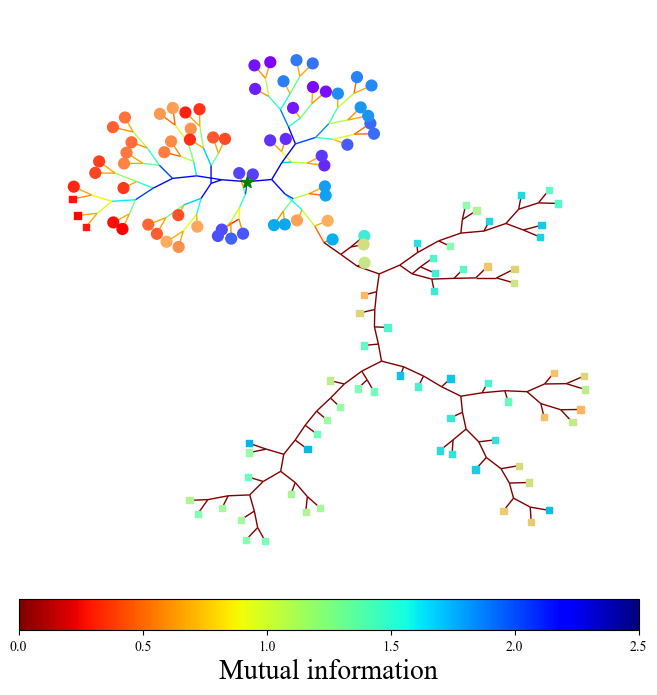

In [7]:
seed = 230701
nleaf = 128
for TY in [
    0,
]:
    for ST in [
        3,
    ]:
        bname = f"./Results/bm_random_TY{TY}_ST{ST}_ALG0_ALP0.05_MAX1_D10_NS10_SE{seed}_XS{seed}"
        with open(bname + ".pickle", "rb") as f:
            bm = pickle.load(f)
        G = make_graph(bm)
        center_mi, distance_mi = distance_from_center(G, weight="mi")
        center, distance = distance_from_center(G, center=center_mi)
        plot_graph(
            G,
            nleaf,
            center_mi,
            select_distance(distance, 0.5),
            #            save=f"random_L{nleaf}_TY{TY}_ST{ST}_seed{seed}",
        )